In [ ]:
# import zipfile

# # Define the path to the zip file and the extraction directory
# zip_path = '/content/drive/MyDrive/Vaay/Newset/Goh.zip'
# extract_dir = '/content/drive/MyDrive/Vaay/Newset/'

# # Unzip the file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print("Unzipping complete.")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
print(len(glob.glob("/content/drive/MyDrive/Vaay/fahime/*")))
print(len(glob.glob("/content/drive/MyDrive/Vaay/Newset/Goh/airport_terminal/*")))
print(len(glob.glob("/content/drive/MyDrive/Vaay/Newset/Goh/bakery/shop/*")))
print(len(glob.glob("/content/drive/MyDrive/Vaay/Newset/Goh/bowling_alley/*")))
print(len(glob.glob("/content/drive/MyDrive/Vaay/Newset/Goh/classroom/*")))
print(len(glob.glob("/content/drive/MyDrive/Vaay/Newset/Goh/music_studio/*")))



3
5000
5000
5000
5000
5000


In [3]:
import os
import shutil
import random
from PIL import Image
from sklearn.model_selection import train_test_split

# Define paths and parameters
data_dir = '/content/drive/MyDrive/Vaay/Newset/Goh/'
output_dir = '/content/drive/MyDrive/Train_test_val'
categories = {
    "airport_terminal": "Airport",
    "bakery/shop": "Bakery",
    "bowling_alley": "Bowling",
    "classroom": "classroom",
    "music_studio": "music_studio"
}
num_images_per_class = 500  # Total images per class
train_size = 350
val_size = 75
test_size = 75
resize_dim = (224, 224)

# Create output directories
for split in ['train', 'val', 'test']:
    for category in categories.values():
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Function to resize and save images
def resize_and_save(img_path, output_path):
    img = Image.open(img_path)
    img = img.resize(resize_dim, Image.ANTIALIAS)
    img.save(output_path)

# Process each category
for category_path, category_name in categories.items():
    full_category_path = os.path.join(data_dir, category_path)
    images = [os.path.join(full_category_path, img) for img in os.listdir(full_category_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Shuffle and select a subset of images
    random.shuffle(images)
    images = images[:num_images_per_class]

    # Split images into training, validation, and test sets
    train_images, test_images = train_test_split(images, test_size=(val_size + test_size) / num_images_per_class, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=test_size / (val_size + test_size), random_state=42)

    # Resize and save images to respective directories
    for img_path in train_images:
        resize_and_save(img_path, os.path.join(output_dir, 'train', category_name, os.path.basename(img_path)))
    for img_path in val_images:
        resize_and_save(img_path, os.path.join(output_dir, 'val', category_name, os.path.basename(img_path)))
    for img_path in test_images:
        resize_and_save(img_path, os.path.join(output_dir, 'test', category_name, os.path.basename(img_path)))

print("Dataset preparation completed.")

<ipython-input-3-e6a821a54502>:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(resize_dim, Image.ANTIALIAS)


Dataset preparation completed.


# Data Distribution

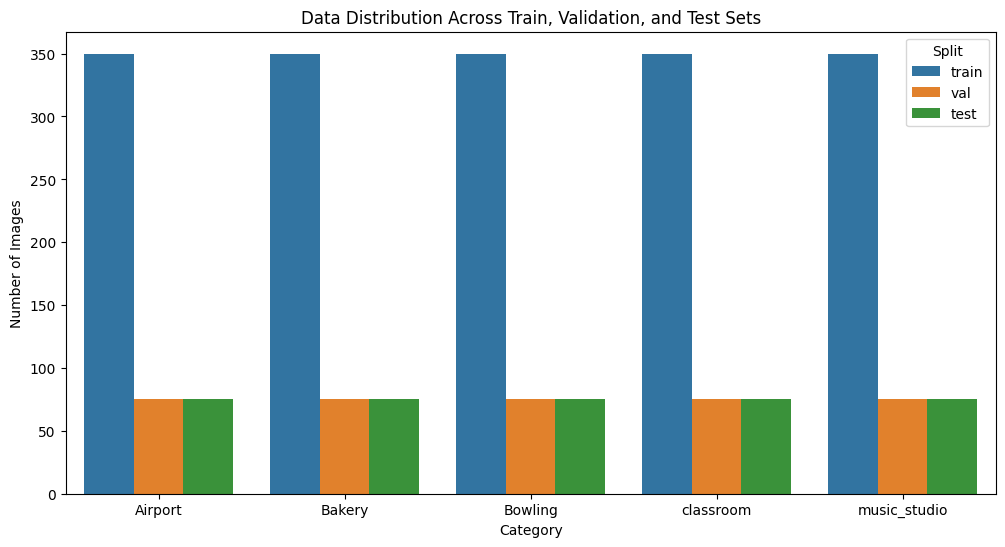

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Calculate the number of images in each category for each split
data_counts = {'Category': [], 'Split': [], 'Count': []}

for split in ['train', 'val', 'test']:
    for category in categories.values():
        category_path = os.path.join(output_dir, split, category)
        count = len(os.listdir(category_path))
        data_counts['Category'].append(category)
        data_counts['Split'].append(split)
        data_counts['Count'].append(count)

# Convert to DataFrame for easier plotting
data_counts_df = pd.DataFrame(data_counts)

# Plot the distribution of data
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Count', hue='Split', data=data_counts_df)
plt.title('Data Distribution Across Train, Validation, and Test Sets')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.legend(title='Split')
plt.show()


# Models

## Supervised Decision Tree


In [10]:
import os
import numpy as np
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Define parameters
data_dir = output_dir# Update with your data directory path
categories = ['Airport', 'music_studio', 'classroom', 'Bakery', 'Bowling']
resize_dim = (224, 224)

# Load dataset
def load_images(data_dir, categories, resize_dim):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_name in tqdm(os.listdir(category_path), desc=f'Loading {category} images'):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path).resize(resize_dim)
            img_array = np.array(img).flatten()  # Flatten the image
            images.append(img_array)
            labels.append(category)
    return np.array(images), np.array(labels)

# Load training data
train_images, train_labels = load_images(os.path.join(data_dir, 'train'), categories, resize_dim)
val_images, val_labels = load_images(os.path.join(data_dir, 'val'), categories, resize_dim)
test_images, test_labels = load_images(os.path.join(data_dir, 'test'), categories, resize_dim)
print("========== Images were loaded successfully ==========\n")

# Encode labels
print("Label Encoding ...")
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)
print("========== Labels were loaded successfully ==========\n")

# Define hyperparameters to test
hyperparameters = [
    {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2},
    {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4},
    {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
]

# Function to train and evaluate the model
def train_and_evaluate(hyperparams):
    print(f"Training with hyperparameters: {hyperparams}")
    dt_classifier = DecisionTreeClassifier(**hyperparams, random_state=42)
    dt_classifier.fit(train_images, train_labels_encoded)

    val_predictions = dt_classifier.predict(val_images)
    test_predictions = dt_classifier.predict(test_images)

    accuracy = accuracy_score(test_labels_encoded, test_predictions)
    precision = precision_score(test_labels_encoded, test_predictions, average='weighted')
    recall = recall_score(test_labels_encoded, test_predictions, average='weighted')
    f1 = f1_score(test_labels_encoded, test_predictions, average='weighted')
    conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")
    return accuracy, precision, recall, f1, conf_matrix, dt_classifier

# Loop through each set of hyperparameters, train and evaluate the model
results = []
models = []
for params in hyperparameters:
    metrics = train_and_evaluate(params)
    results.append(metrics[:-1])
    models.append(metrics[-1])

# Optionally, print or plot the results for comparison
for i, params in enumerate(hyperparameters):
    print(f"Results for hyperparameters {params}:")
    print(f"Accuracy: {results[i][0]}")
    print(f"Precision: {results[i][1]}")
    print(f"Recall: {results[i][2]}")
    print(f"F1 Score: {results[i][3]}")
    print(f"Confusion Matrix:\n{results[i][4]}\n")


Loading Bowling images: 100%|██████████| 75/75 [00:00<00:00, 318.16it/s]


========== Images were loaded successfully ==========

Label Encoding ...
========== Labels were loaded successfully ==========

Training with hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Accuracy: 0.2986666666666667
Precision: 0.3009306742640076
Recall: 0.2986666666666667
F1 Score: 0.2991792985708008
Confusion Matrix:
[[17 12 17 17 12]
 [11 28 15 14  7]
 [13 17 19 13 13]
 [19  7 17 24  8]
 [12 14 13 12 24]]

Training with hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4}
Accuracy: 0.376
Precision: 0.382208726231888
Recall: 0.376
F1 Score: 0.37770747608379684
Confusion Matrix:
[[29  9 13 17  7]
 [16 34 10 10  5]
 [16  4 27 10 18]
 [12 11 16 26 10]
 [10  9 23  8 25]]

Training with hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
Accuracy: 0.31466666666666665
Precision: 0.32278683096704486
Recall: 0.31466666666666665
F1 Score: 0.3175764862665676
Confusion Matrix:
[[20 13 18 17  7]
 [ 7 29 

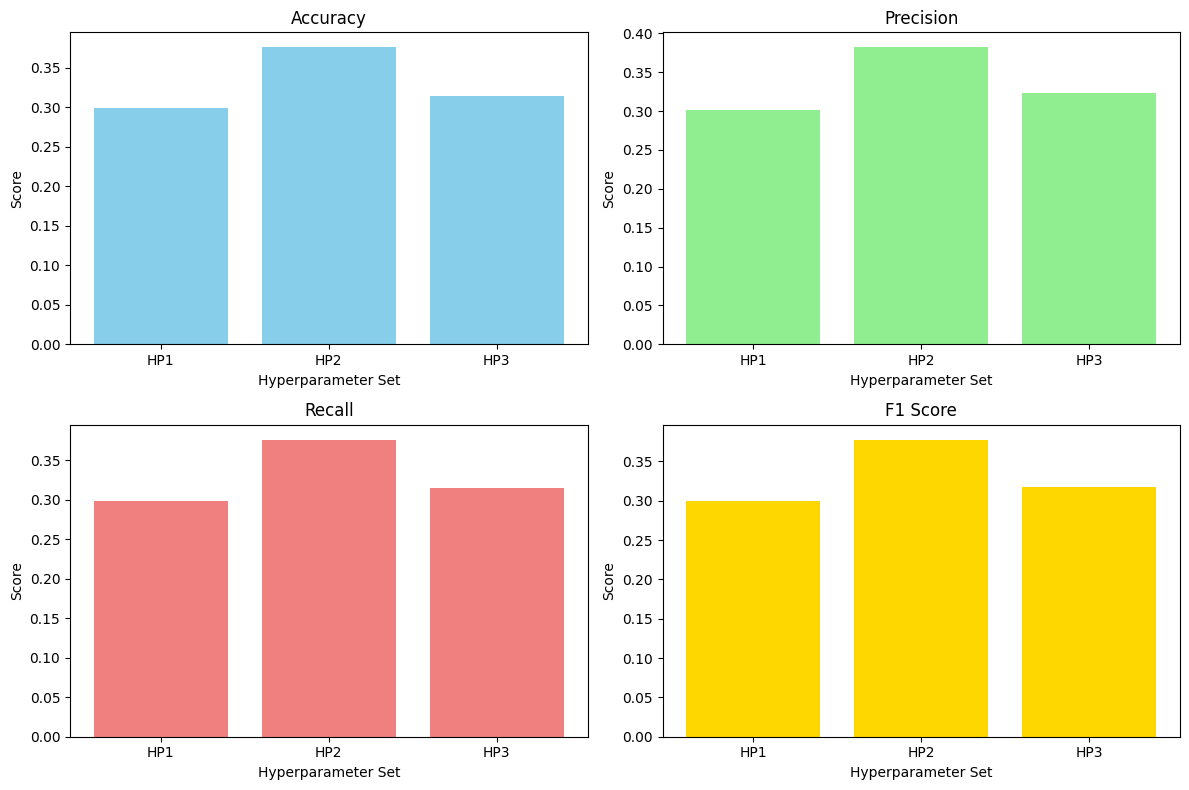

In [11]:
# Plot the results
import matplotlib.pyplot as plt
accuracies = [result[0] for result in results]
precisions = [result[1] for result in results]
recalls = [result[2] for result in results]
f1_scores = [result[3] for result in results]
hyperparam_labels = [f'HP{i+1}' for i in range(len(hyperparameters))]

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(hyperparam_labels, accuracies, color='skyblue')
plt.title('Accuracy')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.bar(hyperparam_labels, precisions, color='lightgreen')
plt.title('Precision')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.bar(hyperparam_labels, recalls, color='lightcoral')
plt.title('Recall')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Score')

plt.subplot(2, 2, 4)
plt.bar(hyperparam_labels, f1_scores, color='gold')
plt.title('F1 Score')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [12]:
# Install graphviz if not already installed
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [13]:

# Import required libraries for visualization
from sklearn.tree import export_graphviz
import graphviz

# Function to visualize and save the decision tree
def visualize_tree(model, feature_names, class_names, file_name):
    dot_data = export_graphviz(model, out_file=None,
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(file_name)
    return graph

# Example of visualizing trees after training
# Assuming 'results' is a list of tuples returned from 'train_and_evaluate' containing the model as the last element

feature_names = [f'pixel_{i}' for i in range(train_images.shape[1])]
class_names = label_encoder.classes_

# Loop through each set of results to visualize and save the decision trees
for i, (accuracy, precision, recall, f1, conf_matrix, model) in enumerate(results):
    file_name = f"decision_tree_{i+1}"
    graph = visualize_tree(model, feature_names, class_names, file_name)
    graph.view()


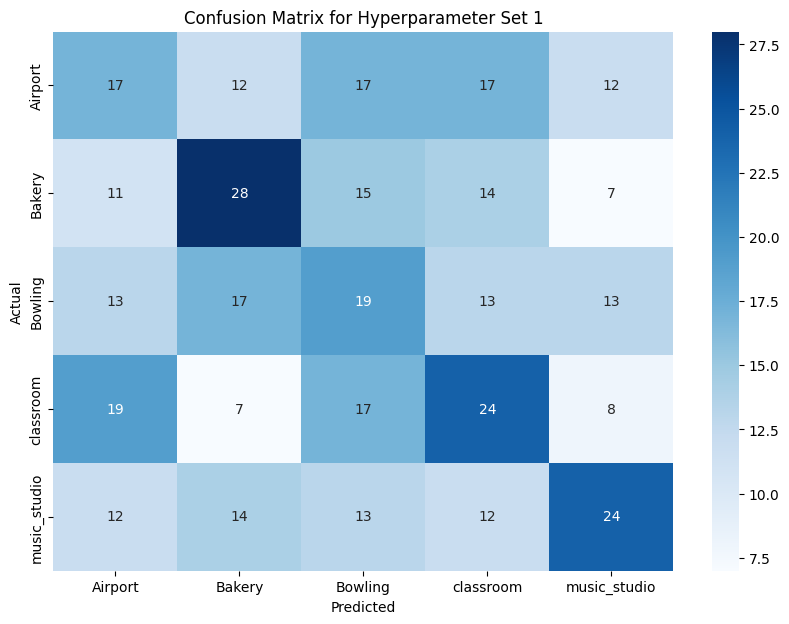

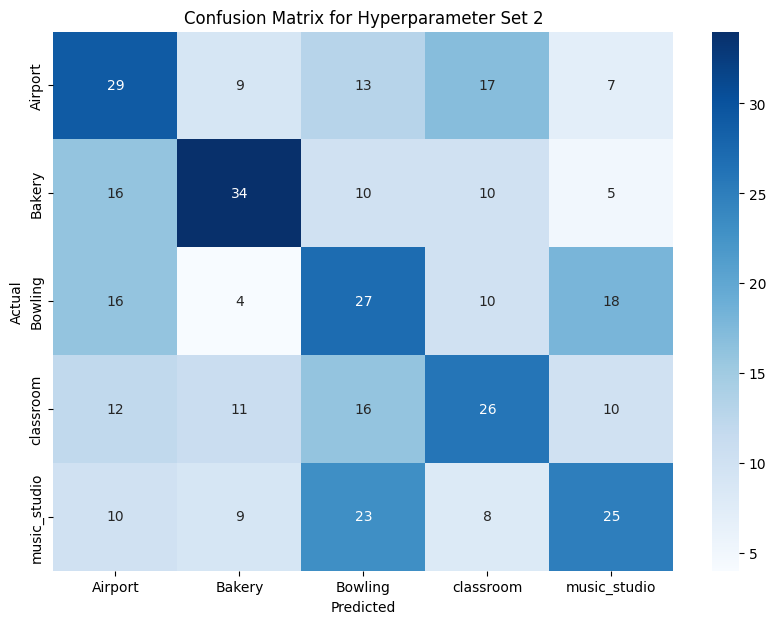

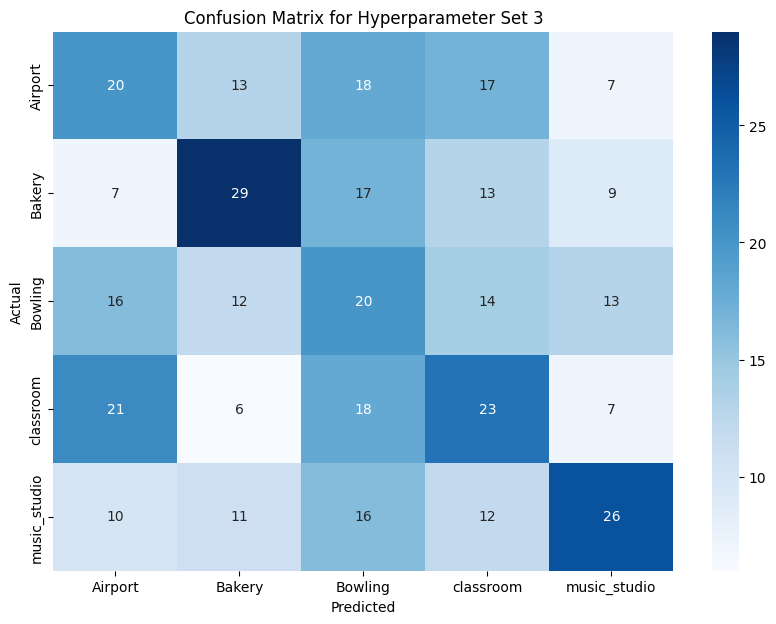

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Assuming 'results' is a list of tuples returned from 'train_and_evaluate' containing the model as the last element

# Evaluate the model and plot confusion matrices for each hyperparameter set
for i, (accuracy, precision, recall, f1, conf_matrix, model) in enumerate(results):
    # Predict on the test set
    test_predictions = model.predict(test_images)
    title = f"Confusion Matrix for Hyperparameter Set {i+1}"
    plot_confusion_matrix(test_labels_encoded, test_predictions, label_encoder.classes_, title)


# TSNE + DT supervised

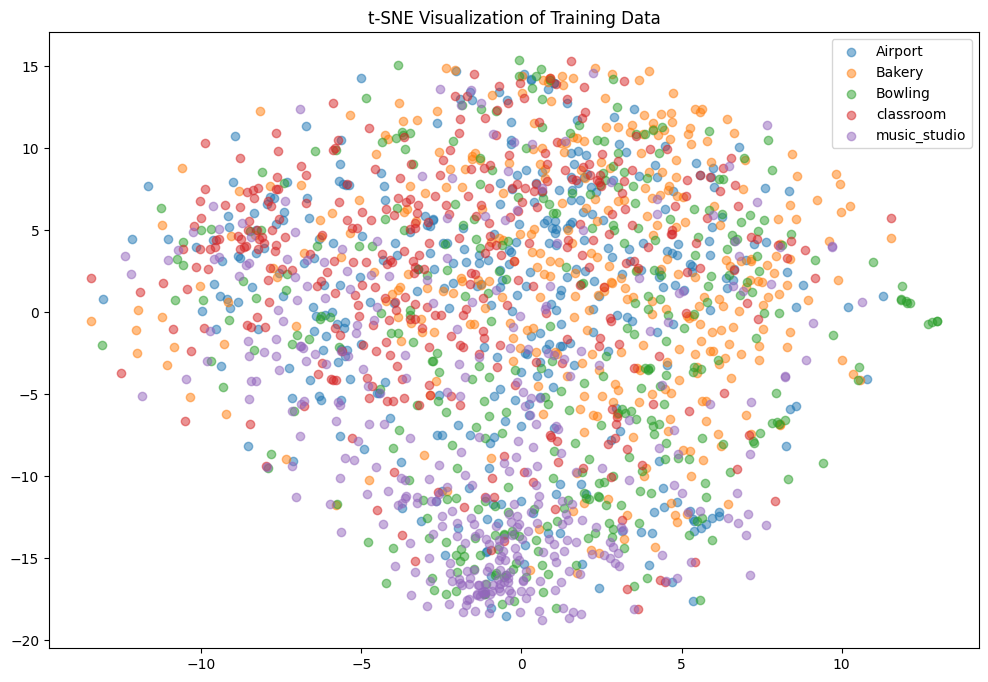

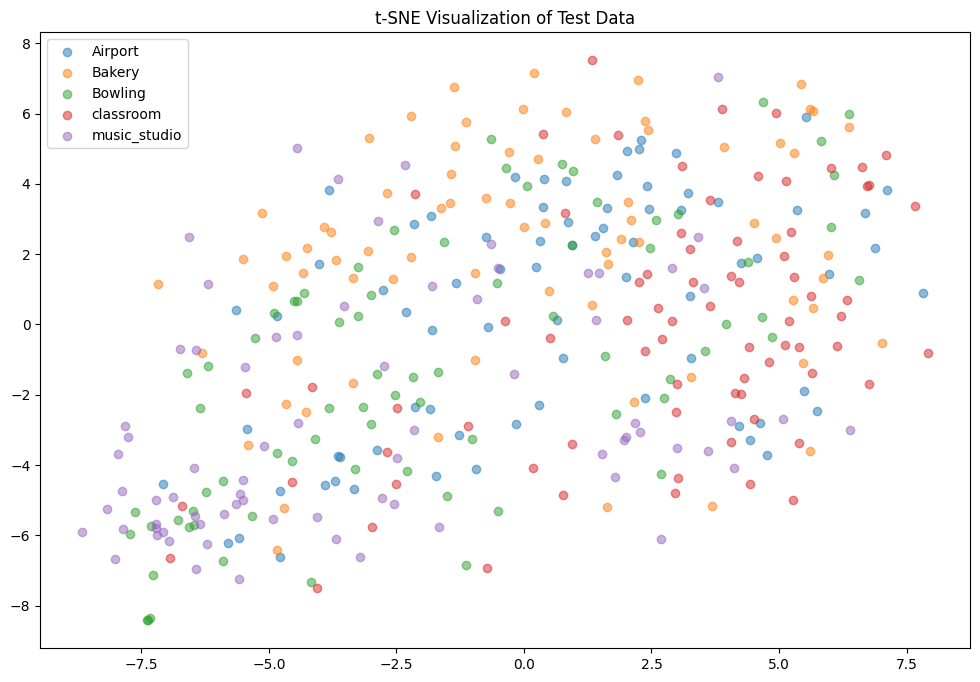

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to plot t-SNE visualization
def plot_tsne(data, labels, title, class_names):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(data)

    plt.figure(figsize=(12, 8))
    for class_index, class_name in enumerate(class_names):
        indices = labels == class_index
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=class_name, alpha=0.5)

    plt.title(title)
    plt.legend()
    plt.show()

# Visualize the training data using t-SNE
plot_tsne(train_images, train_labels_encoded, 't-SNE Visualization of Training Data', label_encoder.classes_)

# Visualize the test data using t-SNE
plot_tsne(test_images, test_labels_encoded, 't-SNE Visualization of Test Data', label_encoder.classes_)


**Combining t-SNE and Confusion Matrix**

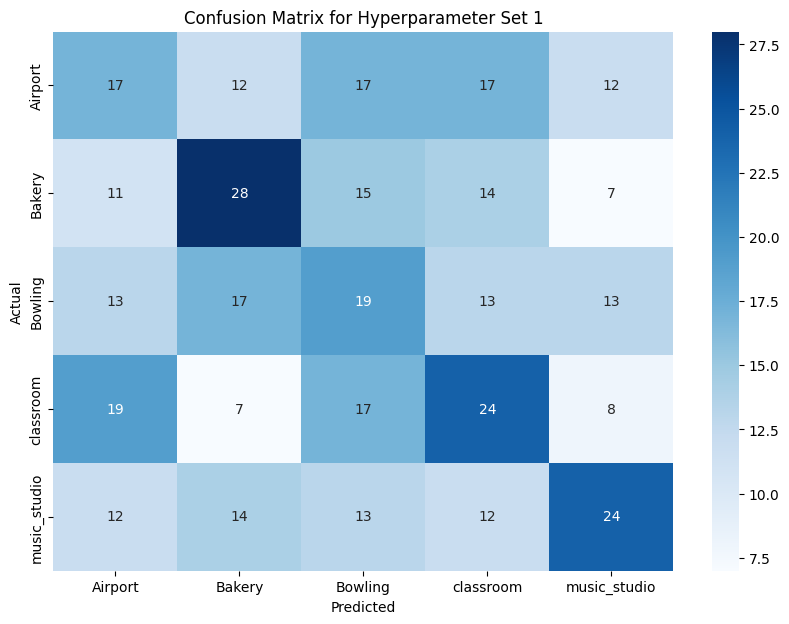

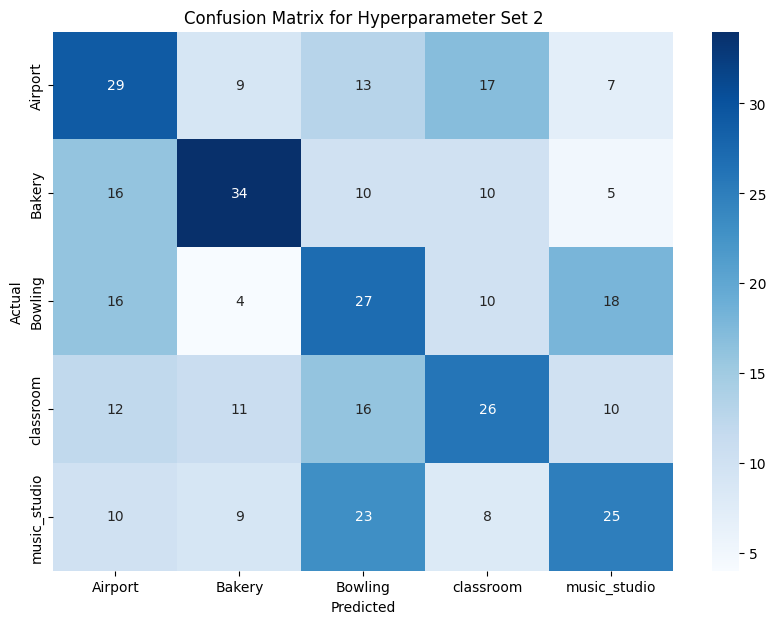

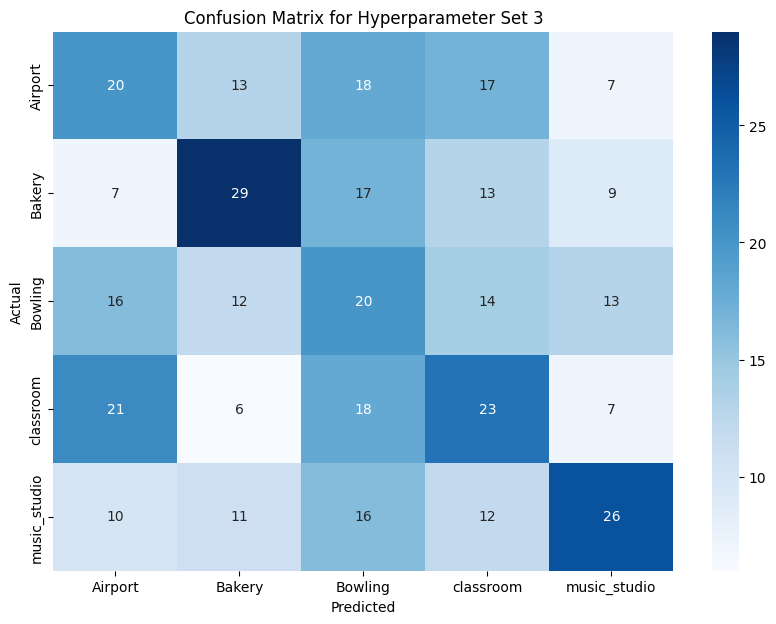

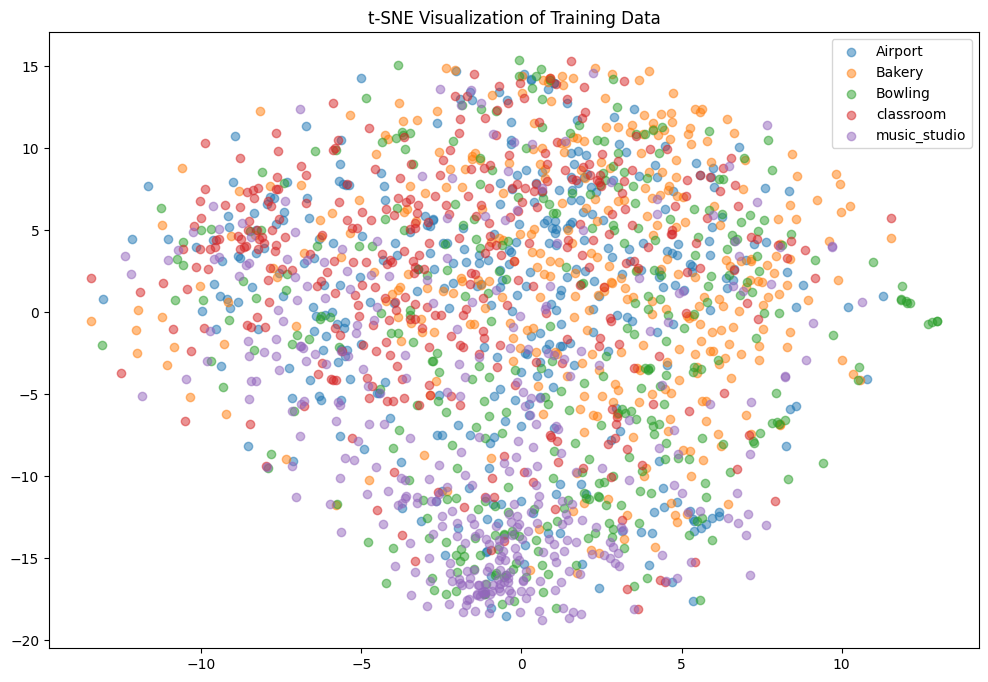

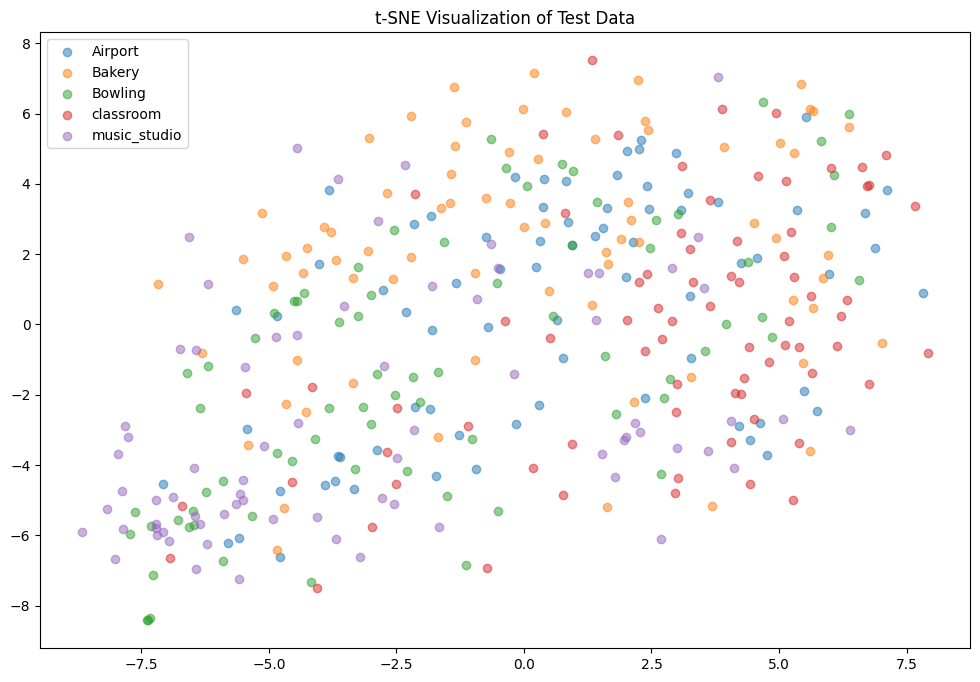

In [16]:
# Plot confusion matrices
for i, (accuracy, precision, recall, f1, conf_matrix, model) in enumerate(results):
    test_predictions = model.predict(test_images)
    title = f"Confusion Matrix for Hyperparameter Set {i+1}"
    plot_confusion_matrix(test_labels_encoded, test_predictions, label_encoder.classes_, title)

# t-SNE visualization
plot_tsne(train_images, train_labels_encoded, 't-SNE Visualization of Training Data', label_encoder.classes_)
plot_tsne(test_images, test_labels_encoded, 't-SNE Visualization of Test Data', label_encoder.classes_)


# **Trees**

In [ ]:
# Install graphviz if not already installed
!apt-get install graphviz
!pip install graphviz


In [19]:
# models = []
# for params in hyperparameters:
#     metrics = train_and_evaluate(params)
#     models.append(metrics[-1])


Training with hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Accuracy: 0.2986666666666667
Precision: 0.3009306742640076
Recall: 0.2986666666666667
F1 Score: 0.2991792985708008
Confusion Matrix:
[[17 12 17 17 12]
 [11 28 15 14  7]
 [13 17 19 13 13]
 [19  7 17 24  8]
 [12 14 13 12 24]]

Training with hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4}
Accuracy: 0.376
Precision: 0.382208726231888
Recall: 0.376
F1 Score: 0.37770747608379684
Confusion Matrix:
[[29  9 13 17  7]
 [16 34 10 10  5]
 [16  4 27 10 18]
 [12 11 16 26 10]
 [10  9 23  8 25]]

Training with hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
Accuracy: 0.31466666666666665
Precision: 0.32278683096704486
Recall: 0.31466666666666665
F1 Score: 0.3175764862665676
Confusion Matrix:
[[20 13 18 17  7]
 [ 7 29 17 13  9]
 [16 12 20 14 13]
 [21  6 18 23  7]
 [10 11 16 12 26]]



In [20]:
# Import required libraries for visualization
from sklearn.tree import export_graphviz
import graphviz

# Function to visualize and save the decision tree
def visualize_tree(model, feature_names, class_names, file_name):
    dot_data = export_graphviz(model, out_file=None,
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(file_name)
    return graph

# Example of visualizing trees after training
feature_names = [f'pixel_{i}' for i in range(train_images.shape[1])]
class_names = label_encoder.classes_

# Loop through each trained model to visualize and save the decision trees
for i, model in enumerate(models):
    file_name = f"decision_tree_{i+1}"
    graph = visualize_tree(model, feature_names, class_names, file_name)
    graph.view()

## Semi-Supervised Dicision Tree

In [25]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split

# Define parameters
data_dir = output_dir  # Update with your data directory path
categories = ['Airport', 'music_studio', 'classroom', 'Bakery', 'Bowling']
resize_dim = (224, 224)

# Load training, validation, and test data
train_images, train_labels = load_images(os.path.join(data_dir, 'train'), categories, resize_dim)
val_images, val_labels = load_images(os.path.join(data_dir, 'val'), categories, resize_dim)
test_images, test_labels = load_images(os.path.join(data_dir, 'test'), categories, resize_dim)
print("========== Images were loaded successfully ==========\n")

# Encode labels
print("Label Encoding ...")
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)
print("========== Labels were loaded successfully ==========\n")

# Split training data into labeled and unlabeled data
labeled_indices, unlabeled_indices = train_test_split(range(len(train_images)), test_size=0.8, random_state=42)
labeled_images = train_images[labeled_indices]
labeled_labels = train_labels_encoded[labeled_indices]
unlabeled_images = train_images[unlabeled_indices]

# Use -1 as labels for unlabeled data
unlabeled_labels = -1 * np.ones(unlabeled_images.shape[0])

# Combine labeled and unlabeled data
semi_supervised_images = np.vstack((labeled_images, unlabeled_images))
semi_supervised_labels = np.concatenate((labeled_labels, unlabeled_labels))

# Define hyperparameters to test
semi_supervised_hyperparameters = [
    {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2},
    {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4},
    {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
]

# Manually train and store models
trained_models_semi = []
results_semi = []

for params in semi_supervised_hyperparameters:
    base_classifier = DecisionTreeClassifier(**params, random_state=42)
    semi_supervised_classifier = SelfTrainingClassifier(base_classifier)
    semi_supervised_classifier.fit(semi_supervised_images, semi_supervised_labels)

    val_predictions_semi = semi_supervised_classifier.predict(val_images)
    test_predictions_semi = semi_supervised_classifier.predict(test_images)

    accuracy_semi = accuracy_score(test_labels_encoded, test_predictions_semi)
    precision_semi = precision_score(test_labels_encoded, test_predictions_semi, average='weighted')
    recall_semi = recall_score(test_labels_encoded, test_predictions_semi, average='weighted')
    f1_semi = f1_score(test_labels_encoded, test_predictions_semi, average='weighted')
    conf_matrix_semi = confusion_matrix(test_labels_encoded, test_predictions_semi)

    results_semi.append((accuracy_semi, precision_semi, recall_semi, f1_semi, conf_matrix_semi))
    trained_models_semi.append(semi_supervised_classifier)

    print(f"Training with hyperparameters: {params}")
    print(f"Accuracy: {accuracy_semi}")
    print(f"Precision: {precision_semi}")
    print(f"Recall: {recall_semi}")
    print(f"F1 Score: {f1_semi}")
    print(f"Confusion Matrix:\n{conf_matrix_semi}\n")


Loading Bowling images: 100%|██████████| 75/75 [00:00<00:00, 277.55it/s]


========== Images were loaded successfully ==========

Label Encoding ...
========== Labels were loaded successfully ==========

Training with hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]

Training with hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4}
Accuracy: 0.2773333333333333
Precision: 0.2858086536315612
Recall: 0.2773333333333333
F1 Score: 0.2786637329827885
Confusion Matrix:
[[16 25 16 11  7]
 [10 29 17 14  5]
 [14 18 15 17 11]
 [12 13 19 20 11]
 [ 9  9 23 10 24]]

Training with hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
Accuracy: 0.2906666666666667
Precision: 0.2942639170610773
Recall: 0.2906666666666667
F1 Score: 0.28854501518582204
Confusion Matrix:
[[13 21 21 11  9]
 [ 9 24 

## Threshold

In [26]:
import os
import numpy as np
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to load images
def load_images(data_dir, categories, resize_dim):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_name in tqdm(os.listdir(category_path), desc=f'Loading {category} images'):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path).resize(resize_dim)
            img_array = np.array(img).flatten()  # Flatten the image
            images.append(img_array)
            labels.append(category)
    return np.array(images), np.array(labels)

# Function to visualize and save the decision tree
def visualize_tree(model, feature_names, class_names, file_name):
    from sklearn.tree import export_graphviz
    import graphviz
    dot_data = export_graphviz(model, out_file=None,
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(file_name)
    return graph


In [27]:
# Define parameters
data_dir = output_dir  # Update with your data directory path
categories = ['Airport', 'music_studio', 'classroom', 'Bakery', 'Bowling']
resize_dim = (224, 224)

# Load training, validation, and test data
train_images, train_labels = load_images(os.path.join(data_dir, 'train'), categories, resize_dim)
val_images, val_labels = load_images(os.path.join(data_dir, 'val'), categories, resize_dim)
test_images, test_labels = load_images(os.path.join(data_dir, 'test'), categories, resize_dim)
print("========== Images were loaded successfully ==========\n")

# Encode labels
print("Label Encoding ...")
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)
print("========== Labels were loaded successfully ==========\n")

# Split training data into labeled and unlabeled data
labeled_indices, unlabeled_indices = train_test_split(range(len(train_images)), test_size=0.8, random_state=42)
labeled_images = train_images[labeled_indices]
labeled_labels = train_labels_encoded[labeled_indices]
unlabeled_images = train_images[unlabeled_indices]

# Use -1 as labels for unlabeled data
unlabeled_labels = -1 * np.ones(unlabeled_images.shape[0])

# Combine labeled and unlabeled data
semi_supervised_images = np.vstack((labeled_images, unlabeled_images))
semi_supervised_labels = np.concatenate((labeled_labels, unlabeled_labels))


Loading Bowling images: 100%|██████████| 75/75 [00:00<00:00, 253.34it/s]


========== Images were loaded successfully ==========

Label Encoding ...
========== Labels were loaded successfully ==========



In [28]:
# Define hyperparameters to test for SelfTrainingClassifier
self_training_hyperparameters = [
    {'threshold': 0.75},
    {'threshold': 0.85},
    {'threshold': 0.95}
]

# Manually train and store models
trained_models_semi = []
results_semi = []

for params in self_training_hyperparameters:
    semi_supervised_classifier = SelfTrainingClassifier(DecisionTreeClassifier(random_state=42), **params)
    semi_supervised_classifier.fit(semi_supervised_images, semi_supervised_labels)

    val_predictions_semi = semi_supervised_classifier.predict(val_images)
    test_predictions_semi = semi_supervised_classifier.predict(test_images)

    accuracy_semi = accuracy_score(test_labels_encoded, test_predictions_semi)
    precision_semi = precision_score(test_labels_encoded, test_predictions_semi, average='weighted')
    recall_semi = recall_score(test_labels_encoded, test_predictions_semi, average='weighted')
    f1_semi = f1_score(test_labels_encoded, test_predictions_semi, average='weighted')
    conf_matrix_semi = confusion_matrix(test_labels_encoded, test_predictions_semi)

    results_semi.append((accuracy_semi, precision_semi, recall_semi, f1_semi, conf_matrix_semi))
    trained_models_semi.append(semi_supervised_classifier)

    print(f"Training with hyperparameters: {params}")
    print(f"Accuracy: {accuracy_semi}")
    print(f"Precision: {precision_semi}")
    print(f"Recall: {recall_semi}")
    print(f"F1 Score: {f1_semi}")
    print(f"Confusion Matrix:\n{conf_matrix_semi}\n")


Training with hyperparameters: {'threshold': 0.75}
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]

Training with hyperparameters: {'threshold': 0.85}
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]

Training with hyperparameters: {'threshold': 0.95}
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]



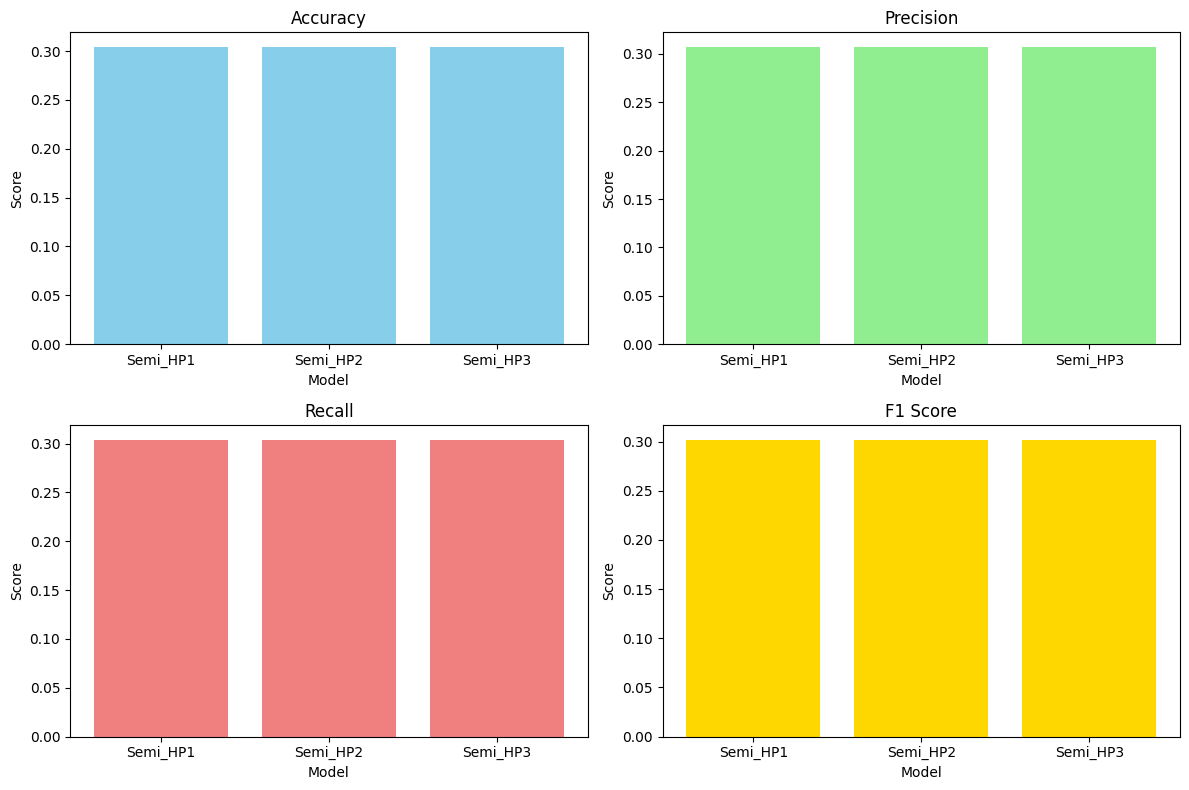

In [29]:
# Prepare labels for plots
hyperparam_labels_semi = [f'Semi_HP{i+1}' for i in range(len(self_training_hyperparameters))]

# Plot the results for semi-supervised models
accuracies_semi = [result[0] for result in results_semi]
precisions_semi = [result[1] for result in results_semi]
recalls_semi = [result[2] for result in results_semi]
f1_scores_semi = [result[3] for result in results_semi]

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(hyperparam_labels_semi, accuracies_semi, color='skyblue')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.bar(hyperparam_labels_semi, precisions_semi, color='lightgreen')
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.bar(hyperparam_labels_semi, recalls_semi, color='lightcoral')
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Score')

plt.subplot(2, 2, 4)
plt.bar(hyperparam_labels_semi, f1_scores_semi, color='gold')
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [30]:
# Print detailed results for semi-supervised models
for i, params in enumerate(self_training_hyperparameters):
    print(f"Results for hyperparameters {params}:")
    print(f"Accuracy: {results_semi[i][0]}")
    print(f"Precision: {results_semi[i][1]}")
    print(f"Recall: {results_semi[i][2]}")
    print(f"F1 Score: {results_semi[i][3]}")
    print(f"Confusion Matrix:\n{results_semi[i][4]}\n")


Results for hyperparameters {'threshold': 0.75}:
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]

Results for hyperparameters {'threshold': 0.85}:
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]

Results for hyperparameters {'threshold': 0.95}:
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]



# Itterative Semi Supervised model

In [31]:
import os
import numpy as np
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to load images
def load_images(data_dir, categories, resize_dim):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_name in tqdm(os.listdir(category_path), desc=f'Loading {category} images'):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path).resize(resize_dim)
            img_array = np.array(img).flatten()  # Flatten the image
            images.append(img_array)
            labels.append(category)
    return np.array(images), np.array(labels)

# Function to visualize and save the decision tree
def visualize_tree(model, feature_names, class_names, file_name):
    from sklearn.tree import export_graphviz
    import graphviz
    dot_data = export_graphviz(model, out_file=None,
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(file_name)
    return graph


In [32]:
# Define parameters
data_dir = output_dir  # Update with your data directory path
categories = ['Airport', 'music_studio', 'classroom', 'Bakery', 'Bowling']
resize_dim = (224, 224)

# Load training, validation, and test data
train_images, train_labels = load_images(os.path.join(data_dir, 'train'), categories, resize_dim)
val_images, val_labels = load_images(os.path.join(data_dir, 'val'), categories, resize_dim)
test_images, test_labels = load_images(os.path.join(data_dir, 'test'), categories, resize_dim)
print("========== Images were loaded successfully ==========\n")

# Encode labels
print("Label Encoding ...")
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)
print("========== Labels were loaded successfully ==========\n")

# Split training data into labeled and unlabeled data
labeled_indices, unlabeled_indices = train_test_split(range(len(train_images)), test_size=0.8, random_state=42)
labeled_images = train_images[labeled_indices]
labeled_labels = train_labels_encoded[labeled_indices]
unlabeled_images = train_images[unlabeled_indices]

# Use -1 as labels for unlabeled data
unlabeled_labels = -1 * np.ones(unlabeled_images.shape[0])

# Combine labeled and unlabeled data
semi_supervised_images = np.vstack((labeled_images, unlabeled_images))
semi_supervised_labels = np.concatenate((labeled_labels, unlabeled_labels))


Loading Bowling images: 100%|██████████| 75/75 [00:00<00:00, 323.08it/s]


========== Images were loaded successfully ==========

Label Encoding ...
========== Labels were loaded successfully ==========



In [33]:
# Define function for iterative training
def iterative_semi_supervised_training(base_classifier, labeled_images, labeled_labels, unlabeled_images, iterations=5, confidence_threshold=0.9):
    all_images = np.vstack((labeled_images, unlabeled_images))
    all_labels = np.concatenate((labeled_labels, -1 * np.ones(len(unlabeled_images))))

    for iteration in range(iterations):
        print(f"Iteration {iteration + 1}")
        base_classifier.fit(all_images[all_labels != -1], all_labels[all_labels != -1])

        # Predict probabilities for unlabeled data
        unlabeled_probabilities = base_classifier.predict_proba(unlabeled_images)
        max_probs = np.max(unlabeled_probabilities, axis=1)
        confident_indices = max_probs > confidence_threshold

        # Get new labeled data
        new_labels = base_classifier.predict(unlabeled_images[confident_indices])

        # Update labeled and unlabeled datasets
        all_labels[len(labeled_labels):][confident_indices] = new_labels

        print(f"Added {sum(confident_indices)} confident predictions to the labeled set.")
        if sum(confident_indices) == 0:
            break

    return base_classifier

# Train and store models
trained_models_semi = []
results_semi = []

semi_supervised_hyperparameters = [
    {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2},
    {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4},
    {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
]

for params in semi_supervised_hyperparameters:
    base_classifier = DecisionTreeClassifier(**params, random_state=42)
    semi_supervised_model = iterative_semi_supervised_training(base_classifier, labeled_images, labeled_labels, unlabeled_images)

    test_predictions_semi = semi_supervised_model.predict(test_images)

    accuracy_semi = accuracy_score(test_labels_encoded, test_predictions_semi)
    precision_semi = precision_score(test_labels_encoded, test_predictions_semi, average='weighted')
    recall_semi = recall_score(test_labels_encoded, test_predictions_semi, average='weighted')
    f1_semi = f1_score(test_labels_encoded, test_predictions_semi, average='weighted')
    conf_matrix_semi = confusion_matrix(test_labels_encoded, test_predictions_semi)

    results_semi.append((accuracy_semi, precision_semi, recall_semi, f1_semi, conf_matrix_semi))
    trained_models_semi.append(semi_supervised_model)

    print(f"Training with hyperparameters: {params}")
    print(f"Accuracy: {accuracy_semi}")
    print(f"Precision: {precision_semi}")
    print(f"Recall: {recall_semi}")
    print(f"F1 Score: {f1_semi}")
    print(f"Confusion Matrix:\n{conf_matrix_semi}\n")


Iteration 1
Added 1400 confident predictions to the labeled set.
Iteration 2
Added 1400 confident predictions to the labeled set.
Iteration 3
Added 1400 confident predictions to the labeled set.
Iteration 4
Added 1400 confident predictions to the labeled set.
Iteration 5
Added 1400 confident predictions to the labeled set.
Training with hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]

Iteration 1
Added 1370 confident predictions to the labeled set.
Iteration 2
Added 1383 confident predictions to the labeled set.
Iteration 3
Added 1380 confident predictions to the labeled set.
Iteration 4
Added 1380 confident predictions to the labeled set.
Iteration 5
Added 1380 confident predictions to the labeled set.
Training with hyperparameters: {'criterion': 'entropy',

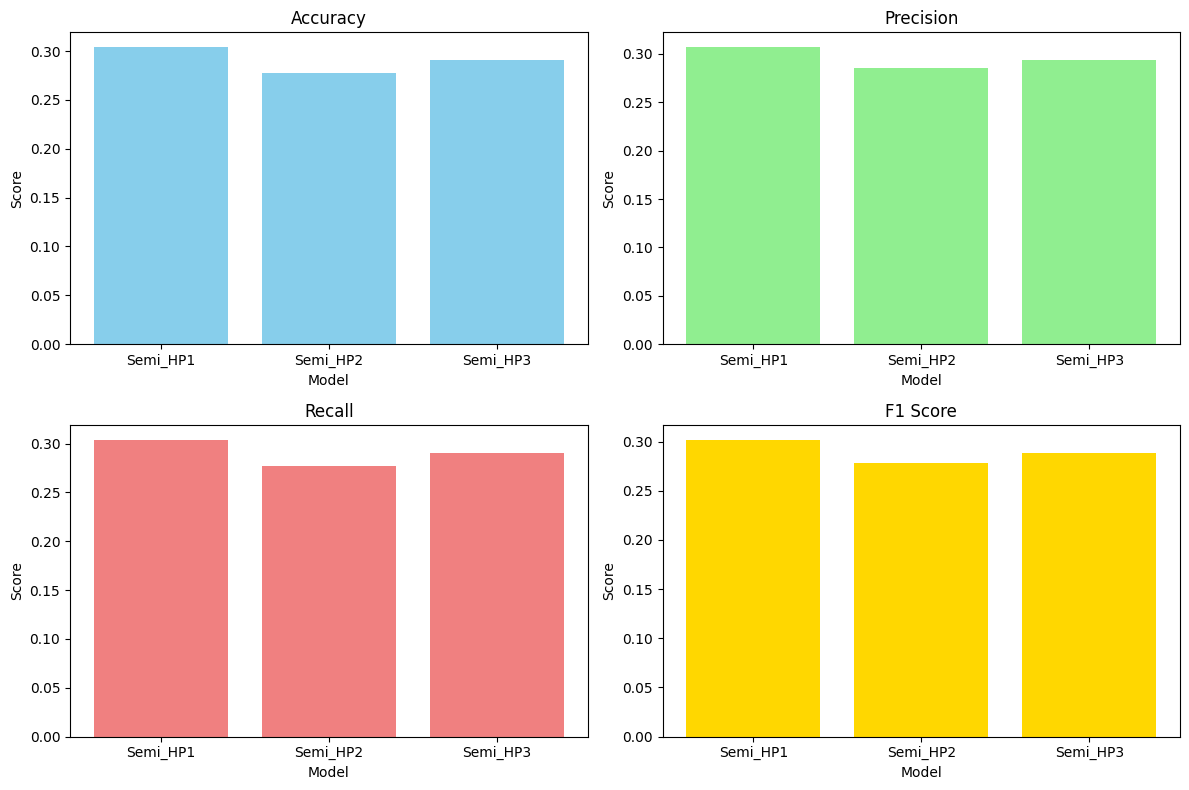

In [34]:
# Prepare labels for plots
hyperparam_labels_semi = [f'Semi_HP{i+1}' for i in range(len(semi_supervised_hyperparameters))]

# Plot the results for semi-supervised models
accuracies_semi = [result[0] for result in results_semi]
precisions_semi = [result[1] for result in results_semi]
recalls_semi = [result[2] for result in results_semi]
f1_scores_semi = [result[3] for result in results_semi]

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(hyperparam_labels_semi, accuracies_semi, color='skyblue')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.bar(hyperparam_labels_semi, precisions_semi, color='lightgreen')
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.bar(hyperparam_labels_semi, recalls_semi, color='lightcoral')
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Score')

plt.subplot(2, 2, 4)
plt.bar(hyperparam_labels_semi, f1_scores_semi, color='gold')
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [35]:
# Print detailed results for semi-supervised models
for i, params in enumerate(semi_supervised_hyperparameters):
    print(f"Results for hyperparameters {params}:")
    print(f"Accuracy: {results_semi[i][0]}")
    print(f"Precision: {results_semi[i][1]}")
    print(f"Recall: {results_semi[i][2]}")
    print(f"F1 Score: {results_semi[i][3]}")
    print(f"Confusion Matrix:\n{results_semi[i][4]}\n")


Results for hyperparameters {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}:
Accuracy: 0.304
Precision: 0.30704886873426196
Recall: 0.304
F1 Score: 0.30186862891087307
Confusion Matrix:
[[15 16 21 13 10]
 [ 7 31 18 13  6]
 [ 8 15 24 13 15]
 [12 16 19 19  9]
 [10 11 17 12 25]]

Results for hyperparameters {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4}:
Accuracy: 0.2773333333333333
Precision: 0.2858086536315612
Recall: 0.2773333333333333
F1 Score: 0.2786637329827885
Confusion Matrix:
[[16 25 16 11  7]
 [10 29 17 14  5]
 [14 18 15 17 11]
 [12 13 19 20 11]
 [ 9  9 23 10 24]]

Results for hyperparameters {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}:
Accuracy: 0.2906666666666667
Precision: 0.2942639170610773
Recall: 0.2906666666666667
F1 Score: 0.28854501518582204
Confusion Matrix:
[[13 21 21 11  9]
 [ 9 24 19 17  6]
 [ 5 19 26 10 15]
 [ 9 12 22 22 10]
 [14 11 14 12 24]]



# Predictions ⚡

## Combine Results and Select the Best Model


In [ ]:
# Combine results from both supervised and semi-supervised models
all_results = results + results_semi
all_models = trained_models + trained_models_semi
all_hyperparams = hyperparameters + semi_supervised_hyperparameters

# Select the best model based on accuracy
best_index = np.argmax([result[0] for result in all_results])
best_model = all_models[best_index]
best_hyperparams = all_hyperparams[best_index]
best_results = all_results[best_index]

print(f"Best model hyperparameters: {best_hyperparams}")
print(f"Best model results:")
print(f"Accuracy: {best_results[0]}")
print(f"Precision: {best_results[1]}")
print(f"Recall: {best_results[2]}")
print(f"F1 Score: {best_results[3]}")
print(f"Confusion Matrix:\n{best_results[4]}")


## Predict and Visualize Results on Test Images

In [ ]:
# Combine results from both supervised and semi-supervised models
all_results = results + results_semi
all_models = trained_models + trained_models_semi
all_hyperparams = hyperparameters + semi_supervised_hyperparameters

# Select the best model based on accuracy
best_index = np.argmax([result[0] for result in all_results])
best_model = all_models[best_index]
best_hyperparams = all_hyperparams[best_index]
best_results = all_results[best_index]

print(f"Best model hyperparameters: {best_hyperparams}")
print(f"Best model results:")
print(f"Accuracy: {best_results[0]}")
print(f"Precision: {best_results[1]}")
print(f"Recall: {best_results[2]}")
print(f"F1 Score: {best_results[3]}")
print(f"Confusion Matrix:\n{best_results[4]}")


## Evaluate the Best Model


In [ ]:
# Evaluate the best model on the test set
accuracy_best = accuracy_score(test_labels_encoded, test_predictions_best)
precision_best = precision_score(test_labels_encoded, test_predictions_best, average='weighted')
recall_best = recall_score(test_labels_encoded, test_predictions_best, average='weighted')
f1_best = f1_score(test_labels_encoded, test_predictions_best, average='weighted')
conf_matrix_best = confusion_matrix(test_labels_encoded, test_predictions_best)

print(f"Evaluation of the Best Model:")
print(f"Accuracy: {accuracy_best}")
print(f"Precision: {precision_best}")
print(f"Recall: {recall_best}")
print(f"F1 Score: {f1_best}")
print(f"Confusion Matrix:\n{conf_matrix_best}")